# Term1 Sprint5 授業課題 
## コーディング課題：SVM分類器スクラッチ

NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していく。  
SVMは分類と回帰双方に使用できるが、分類のみを扱う。  
SVMで重要な要素としてカーネルがあるが、まずは線形カーネルを作成する。他のカーネルの作成はアドバンス課題とする。

## 1. SVM分類器のクラスを作成する
SVM分類器のクラスを作成し、Sprint0で作成した分類のパイプラインに組み込む。  
クラスの基本構造はSprint3の線形回帰を参考にし、名前はScratchSVMClassifierとする。
メソッドやパラメータなどはscikit-learnを参考にする。
[sklearn.svm.SVC — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html "sklearn.svm.SVC — scikit-learn 0.20.2 documentation")

**scikit-learnにおけるパラメータについて**

scikit-learnの実装はソフトマージンSVMになっている。  
ハードマージンSVMを再現するには、パラメータCをC=1e+10のように非常に大きな値を設定する。  
無限大に向けてCを大きくするほどハードマージンSVMに近づく。  
また、線形カーネルをscikit-learnで使う場合はkernel="linear"と指定する。  
デフォルトではkernel="rbf"になっており、放射基底関数(Radial Basis Function)と呼ばれるものになっている。

**ラグランジュの未定乗数法による最急降下**

SVMの最適化問題は、ラグランジュの未定乗数法により解くことができる。  
サンプル数分のラグランジュ乗数$\lambda$を用意して、以下の式により更新していく。
$$\lambda_i^{new} = \lambda_i + \alpha(1 - \sum_{j=1}^{n}{\lambda_j y_i y_j k(x_i, x_j)})$$

ここで$k(x_i,x_j)$はカーネル関数であり、線形カーネルの場合は次のようになる。  
他のカーネル関数にも対応できるように、この部分はメソッド化しておく。
$$k(x_i, x_j) = x_{i}^{T} x_j$$

条件として、更新毎に$\lambda_i\geq0$を満たす必要がある。満たさない場合は$\lambda_i\geq0$とする。

$i,j$ : サンプルのインデックス  
$\lambda_i^{new}$ : 更新後の$i$番目のサンプルのラグランジュ乗数  
$\lambda_i$ : 更新前の$i$番目のサンプルのラグランジュ乗数  
$\alpha$ : 学習率  
$\lambda_j$ : $j$番目のサンプルのラグランジュ乗数  
$y_i$ : $i$番目のサンプルのラベル  
$y_j$ : $j$番目のサンプルのラベル  
$x_i$ : $i$番目のサンプルの特徴量ベクトル  
$x_j$ : $j$番目のサンプルの特徴量ベクトル  

**サポートベクターの決定**

計算したラグランジュ乗数$\lambda$が設定した閾値より大きいサンプルをサポートベクターとして扱う。推定時にサポートベクターが必要となる。  
閾値はハイパーパラメータで、1e-5程度からはじめるとよい。

**推定**

推定時には、推定したいデータの特徴量とサポートベクターの特徴量をカーネル関数によって計算する。求めた$y(x)$の符号が分類結果となる。
$$y(x) = \sum_{n=1}^{N}\lambda_n y_n k(x, s_n)$$

$x$ : 推定したいデータの特徴量ベクトル  
$N$ : サポートベクターの数  
$n$ : サポートベクターのインデックス  
$\lambda_n$ : $n$番目のサポートベクターのラグランジュ乗数  
$y_n$ : $n$番目のサポートベクターのラベル  
$k()$ : カーネル関数  
$s_n$ : $n$番目のサポートベクターの特徴量  

**これまでのまとめ**

SVMによるマージン最大化問題が以下の式の双対表現に帰着できる。
$$\mathrm{argmin}_{w,b}\frac{1}{2}||w||^2$$
この制約付き最小化問題を解くために、ラグランジュ乗数$\lambda$を導入し、$w$と$b$の制約条件を用いて、$\theta$と$\theta_0$を消去すれば、
$$L(\lambda) = \sum_{i=1}^{n} \lambda_i -\frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n}\lambda_{i}\lambda_{j}y_{i}y_{j}x_i^Tx_j$$
という関数が得られ、この関数を$\lambda$に対して最大化すればよい。この$\lambda$の最適解を求める方法はこれまで学んだ勾配降下法を用いる。  
$\lambda$がわかれば$\theta$と$\theta_0$が求まるので、分類境界線が求まる。  


## 2. 指標値の算出
分類に関する指標値で精度を確認する。

## 3. 決定領域の可視化
2値分類のデータセットに対して決定領域を可視化する。  
これまで使用してきた関数に、サポートベクターを色を変えて表示する機能を加える。  
特にSprint0で作成したシンプルデータセット1に対して分類ができるかを検証する。

## 4. 時間の計測
SVMの学習には時間がかかるため、効率的な実装が望まれる。  
事前学習期間に行なったように、時間を計測して改善していく。  
特に$\lambda$の更新部分は繰り返し処理が多いため、効率的なコードを目指す。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class ScratchSVMClassifier:
    """
    ラグランジュ未定乗数法の制約条件に従ったイテレーションによるSVMClassifierのスクラッチ実装（最急降下法ではない）

    Parameters
    ----------
    n_iter : int （初期値： 50）
      イテレーション数
    C : float （初期値： 1e+10）
      スラック変数を導入したソフトマージンにおけるパラメータC
      （初期値のように無限大に近い値ではハードマージンに相当する）

    Attributes
    ----------
    self.evaluation_ : list of float, shape (self.iter,)
      訓練データによるイテレーション毎の評価関数値の記録
    self.lam_ : 次の形のndarray, shape (n_samples,)
      学習後の、各サンプル点のラグランジュ未定乗数の値
    self.w_ : 次の形のndarray, shape (n_features,)
      重みパラメータ
    self.w0_ : float
      バイアス項
    """
    def __init__(self, n_iter=50, C=1e+10):
        self.n_iter = n_iter
        self.C = C
        self.evaluation_ = [0,]
    
    def fit(self, X, y):
        # 初期値設定
        lam = np.zeros(X.shape[0]) # ラグランジュ未定乗数ラムダの初期値（要素数：サンプル数）
        lamy = 0 # lamとyの内積の初期値
        lamyx = np.zeros(X.shape[1]) # lamとyとXの内積の初期値（要素数：特徴量数）
        
        # 固定値算出（最初から作れる）
        yx = y.reshape(-1,1) * X # X^T * y
        # データ点識別用の番号生成
        indices = np.arange(X.shape[0])
        
        # 勾配学習
        for g in range(self.n_iter):
            # データ番号列（0列目）とy * 勾配の列（1列目）の行列index_y_gradを生成
            gradient = 1 - np.dot(yx, lamyx.T) # 勾配計算（サンプル数,）
            y_grad = y * gradient # y * 勾配（サンプル数,）
            index_y_grad = np.c_[indices, y_grad] # indexを0列目に追加（サンプル数, 2）
            
            # i（ラベル-1の点のうちy * 勾配が最小のデータ番号）を決定
            # (y=+1かつlam>0)または（y=-1かつlam<self.C）の行を抽出
            row_minus = index_y_grad[((y>0) & (lam>0)) | ((y<0) & (lam<self.C)), :]
            min_row_minus = np.argmin(row_minus[:, 1]) # その中でy * 勾配が最小の行インデックスを決定
            i = int(row_minus[min_row_minus, 0]) # その行インデックスに該当するデータ番号を格納
            
            # j（ラベル+1の点のうちy * 勾配が最大のデータ番号）を決定
            # (y=-1かつlam>0)または（y=+1かつlam<self.C）の行を抽出
            row_plus = index_y_grad[((y<0) & (lam>0)) | ((y>0) & (lam<self.C)), :] # y = +1またはlam>0の行を抽出
            max_row_plus = np.argmax(row_plus[:, 1]) # その中でy * 勾配が最大の行インデックスを決定
            j = int(row_plus[max_row_plus, 0]) # その行インデックスに該当するデータ番号を格納
            
            # KKT条件から導出する最適解の条件式を満たしているか確認
            if y_grad[i] >= y_grad[j]:
                break
            
            # 満たしていなければパラメータ更新フローに入る
            lamy2 = lamy - lam[i] * y[i] - lam[j] * y[j] # lamyの現在の仮変数を計算
            lamyx2 = lamyx - lam[i] * y[i] * X[i, :] - lam[j] * y[j] * X[j, :] # lamyxの現在の仮変数を計算
            
            # lamy2とlamyx2を使い、制約条件を無視したlam_iをまず作成
            lam_i = (1 - y[i] * y[j] + y[i] * np.dot(X[i, :] - X[j, :], X[j, :] * lamy2 - lamyx2)) / (((X[i] - X[j])**2).sum())
            # 制約条件：lamの値は0以上self.C以下
            if lam_i < 0:
                lam_i = 0
            elif lam_i > self.C:
                lam_i = self.C
            # lam_iが決まればlam_jが決まる
            lam_j = y[j] * (-lam_i * y[i] - lamy2)
            # 制約条件：lamの値は0以上self.C以下
            if lam_j < 0:
                lam_j = 0
                lam_i = y[i] * (-lam_j * y[j] - lamy2) # lam_jが変わる場合は改めて計算
            elif lam_j > self.C:
                lam_j = self.C
                lam_i = y[i] * (-lam_j * y[j] - lamy2) # lam_jが変わる場合は改めて計算
            
            # lamyとlamyxの変化分で更新
            lamy += (lam_i - lam[i]) * y[i] + (lam_j - lam[j]) * y[j]
            lamyx += (lam_i - lam[i]) * y[i] * X[i, :] + (lam_j - lam[j]) * y[j] * X[j, :]
            
            # 計算されたlam_iに変化がなければ終了、あれば更新
            if lam_i == lam[i]:
                break
            lam[i] = lam_i
            lam[j] = lam_j
            
            # 評価関数L（最大化）の値をリストに格納
            evaluation = lam.sum() - (1/2) * lamyx.sum()
            self.evaluation_.append(evaluation)
        
        # 学習が終わったらラグランジュ乗数と学習係数をインスタンス変数に格納
        self.lam_ = lam
        ind = lam != 0. # ラグランジュ乗数が更新されたサンプルのインデックス
        self.w_ = ((lam[ind] * y[ind]).reshape(-1,1) * X[ind, :]).sum(axis=0) # lam*y*Xのサンプル方向の和（要素数：特徴量数）
        # lam!=0の全サンプルでy * f(x)=1となることを利用して算出したw_0値の平均をとる
        self.w0_ = (y[ind] - np.dot(X[ind, :], self.w_)).sum() / ind.sum()
        
        # 評価関数Lの値の推移を可視化
        print("評価関数Lの値の推移（最大化）：\n", self.evaluation_)
        plt.plot(np.arange(len(self.evaluation_)), self.evaluation_, label="evaluation func")
        plt.xlabel("n_iter")
        plt.ylabel("evaluation func value")
        plt.legend(loc="best")
        plt.show()
        
    def predict(self, X):
        return np.sign(self.w0_ + np.dot(X, self.w_))
        

In [2]:
# シンプルデータセット1
import numpy as np

np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]

f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))

X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)

random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]

In [3]:
import sys
sys.path.append("../ml-scratch/models/")
import pipe_clf
from importlib import reload
reload(pipe_clf)

<module 'pipe_clf' from '../ml-scratch/models/pipe_clf.py'>

Cに小さい値を設定して、境界近傍点（サポートベクタ）を増やしてみる。

評価関数Lの値の推移（最大化）：
 [0, 0.007030877793513987, 0.0710435360206905, 0.04503250215487779, 0.08746853921213951, 0.10668996639626285, 0.1352125964091584, 0.13988041151914432, 0.1550041964112201, 0.18605113366769482, 0.1954011459605521, 0.21576717563304215, 0.24568530189982452, 0.25831025498554333, 0.2816861621024861, 0.2940812603260447, 0.32634720573511006, 0.33511902142775085, 0.3669203762397235, 0.3774549576850178, 0.40416862117998426, 0.4253237211885861, 0.42648955504047525, 0.436471430148032, 0.4402619945856613, 0.45087263324075133, 0.4844982146894372, 0.4542360836058735, 0.46658382831075096, 0.4782165096105543, 0.4833830543476498, 0.4929623066123578, 0.47556636416177445, 0.47426628046742697, 0.48978438022115095, 0.48797048544682875, 0.4892814646157537, 0.4893426905088961, 0.4894918965944344, 0.4895549137234497, 0.48954954262990086, 0.4895499964500979, 0.4895499898448584, 0.4895499762290748, 0.48954997840488085, 0.4895499701485325, 0.48954997146789936, 0.48954996646140925, 0.4895499602967

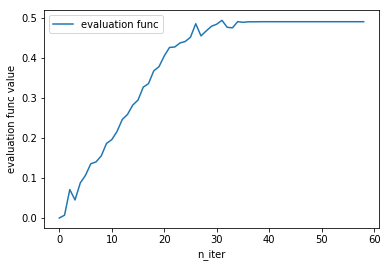

fitting time : 0.33399295806884766s


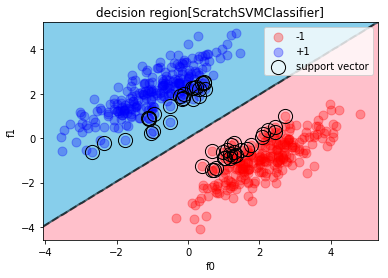

In [4]:
import matplotlib.pyplot as plt
import time

# スクラッチモデルで学習（Cを小さい値にしてみる）
model = ScratchSVMClassifier(n_iter=500, C=0.01)
t0 = time.time() #時間計測開始
model.fit(X, y)
t1 = time.time() #時間計測終了
print('fitting time : {}s'.format(t1-t0))

# 決定領域を描画
pipe_clf.decision_region(X, y, model, target_names=["-1","+1"], 
                         model_name="ScratchSVMClassifier", feature_names=["f0","f1"], sv_show=True)

Cを大きい値にして、最小数のサポートベクタで分割を試してみる。

評価関数Lの値の推移（最大化）：
 [0, 0.08015450328484464, 0.33156757938389303, 0.957071186666469, 0.8769166833816242, 0.6748489149482123, 1.249985352416313, 1.2006400447506764, 1.2501349346386017, 1.273589898979866, 1.2587124534094498, 1.2615404415419629, 1.259935292236634, 1.259904260706171, 1.2598662241278513, 1.2598903506673507, 1.2598857645596713, 1.2598886735202814, 1.2598881205687653, 1.2598884713050085, 1.2598884046351002, 1.2598884469237144, 1.2598884388852578, 1.259888443984038, 1.2598884430148334, 1.2598884436295978, 1.25988844351274, 1.259888443586863, 1.2598884435727735, 1.2598884435817106, 1.2598884435800117, 1.2598884435809756, 1.2598884435810023, 1.259888443581004, 1.2598884435810034, 1.2598884435810043, 1.259888443581004, 1.2598884435810038, 1.2598884435810036]


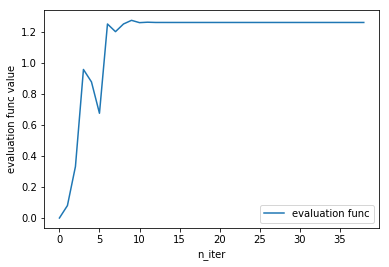

fitting time : 0.23864197731018066s


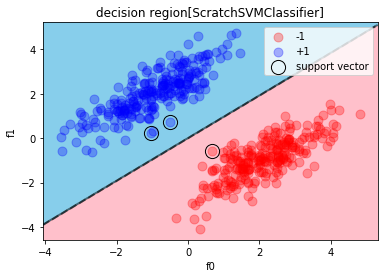

In [5]:
import matplotlib.pyplot as plt
import time

# スクラッチモデルで学習（Cを大きい値にしてみる）
model = ScratchSVMClassifier(n_iter=500, C=1)
t0 = time.time() #時間計測開始
model.fit(X, y)
t1 = time.time() #時間計測終了
print('fitting time : {}s'.format(t1-t0))

# 決定領域を描画
pipe_clf.decision_region(X, y, model, target_names=["-1","+1"], 
                         model_name="ScratchSVMClassifier", feature_names=["f0","f1"], sv_show=True)

irisデータで分類を試みてみる。

/Users/arimoto/anaconda3/envs/python37/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


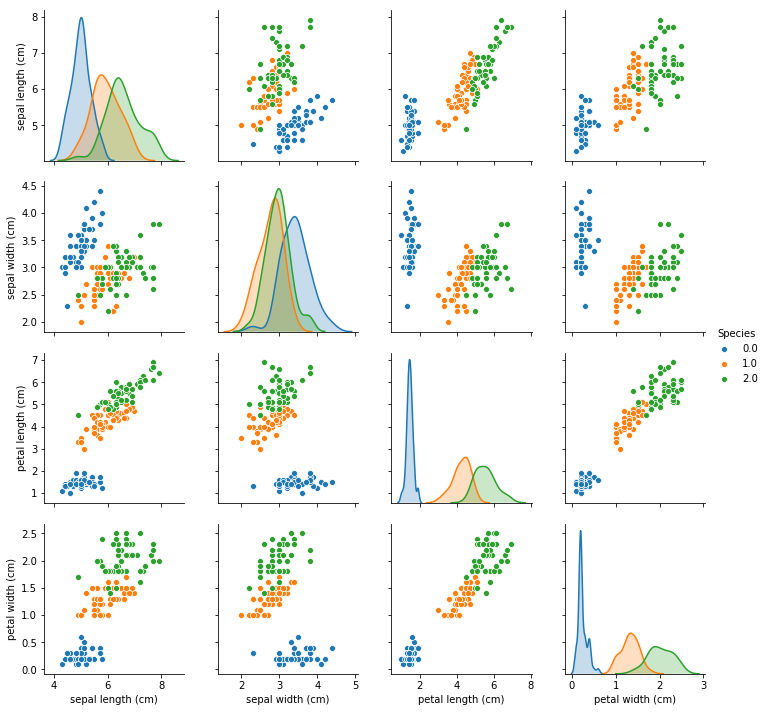

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris

iris = load_iris()
X_iris = iris.data
y_iris = iris.target

df = pd.DataFrame(np.hstack((X_iris, y_iris.reshape(-1,1))), columns=iris.feature_names+["Species"])

sns.pairplot(df, vars=df.columns[:-1], hue="Species") 

特徴量1と3, ラベル1と2で分類を試してみる

評価関数Lの値の推移（最大化）：
 [0, 6.888888888888886, 16.937818552497443, 21.891946992864415, 31.61671763506625, 36.57084607543323, 43.29714576962283, 47.42099898063201, 58.70000599628231, 59.13452640651777, 70.93458037305851, 72.3326372784009, 73.20167809887182, 85.67874231905533, 87.98478266150447, 97.0079882740247, 106.95814009465684, 107.32062893863164, 113.87409808080378, 115.136591634177, 125.54327869817651, 126.30853292434557, 130.43238613535476, 130.88413084407378, 137.3091411154193, 139.8231729769957, 140.50724718772918, 143.1447341417953, 144.0508621604536, 158.25400346787092, 155.97432792965495, 159.27118662223762, 156.11873045388967, 158.30030078128024, 158.5557368512841, 169.58499125488638, 168.9447432839182, 169.0652733716776, 171.1851192024605, 171.32287493299805, 171.01316625129328, 171.28766938720364, 171.5151148426722, 170.17927800639694, 170.4687093209233, 170.0117361076763, 170.27420277374634, 170.4916751542044, 170.28089423160662, 170.0307366531389, 170.29115710662063, 172.4859

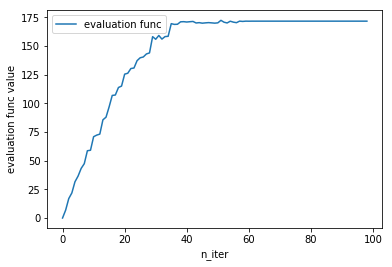

fitting time : 0.2884969711303711s


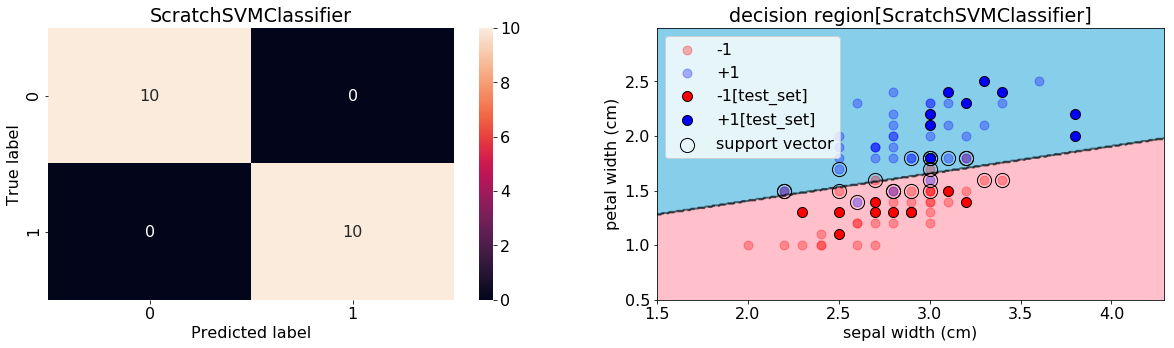

,train_accuracy,test_accuracy,test_precision,test_recall,test_f1_score
ScratchSVMClassifier,0.91,1.0,1.0,1.0,1.0


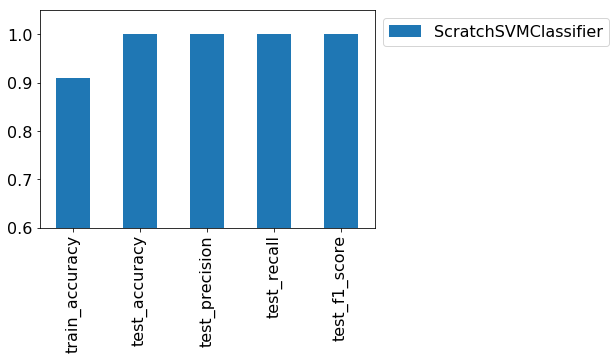

In [7]:
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split


# 特徴量1と3, ラベル1と2で分類を試す
X_train, X_test, y_train, y_test = train_test_split(X_iris[50:, (1,3)], y_iris[y_iris!=0], 
                                                    test_size=0.2, stratify=y_iris[y_iris!=0], random_state=0)

# ラベルを-1と+1に改めて割付
y_train = np.where(y_train==1, -1, 1)
y_test = np.where(y_test==1, -1, 1)

# スクラッチモデルで学習
model = ScratchSVMClassifier(n_iter=5000, C=10)
t0 = time.time() #時間計測開始
model.fit(X_train, y_train)
t1 = time.time() #時間計測終了
print('fitting time : {}s'.format(t1-t0))

# 評価スコア算出と決定領域描画
model_names = ["ScratchSVMClassifier"]
models = [model, ]
feature_names = [iris.feature_names[1]]+[iris.feature_names[3]]
target_names=["-1","+1"]
test_idx=range(80,100)

pipe_clf.scoring_func(X_train, X_test, y_train, y_test, 
                      model_names, models, feature_names, target_names, test_idx, sv_show=True)

スラック変数を導入しているので、マージン内外にサポートベクタが入ってきた場合でも決定境界を描画できていることがわかる。

## 5. Logistic回帰とSVM
最終発表時に以下の内容についてディスカッションを行う。自分なりの意見を用意しておく。  

- ロジスティック回帰とSVMは本質的に何が異なっているか  

**注意点**  
答えがある問いではない。いろいろな視点から見て理解を深めていく。

ロジスティック回帰は多項式関数の連続値にシグモイド関数を適用して0から1の範囲に変換し、中間値の0.5を判断基準とした値の大小で2値分類する。それに対してSVMでは、データ群を超平面で分割可能という前提・仮定の元、その境界面近傍のデータ点群（サポートベクター）に焦点を当て、それらと境界面との距離を最大化することで境界面を決定する。これにより、境界で別れたデータ点群のそれぞれにラベルを割り当てることで分類を予測する。ロジスティック回帰では、各特徴量の回帰係数に重み付けをして学習し、最終的にシグモイド関数で「確率」の概念に帰結させる。一方、SVMではあくまで特徴量空間におけるデータ群間の「距離」に着目し、その境界面を定めることで幾何的に分類する点においてロジスティック回帰分類とは大きく異なる。